### Tinkering with pulling out yard lines and numbers for mapping the field



In [2]:
from roboflow import Roboflow
# load API key from .env.local
import os
from dotenv import load_dotenv
load_dotenv()
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("lucasland").project("marching-band-drill-analysis-mheaa")
version = project.version(1)
dataset = version.download("coco", location="data/drill")

loading Roboflow workspace...
loading Roboflow project...


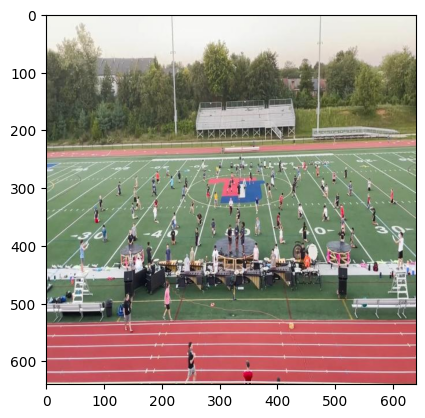

In [3]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
train_images = glob(dataset.location + "/train/*.jpg")
train_image = cv2.imread(train_images[0])
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
plt.imshow(train_image)

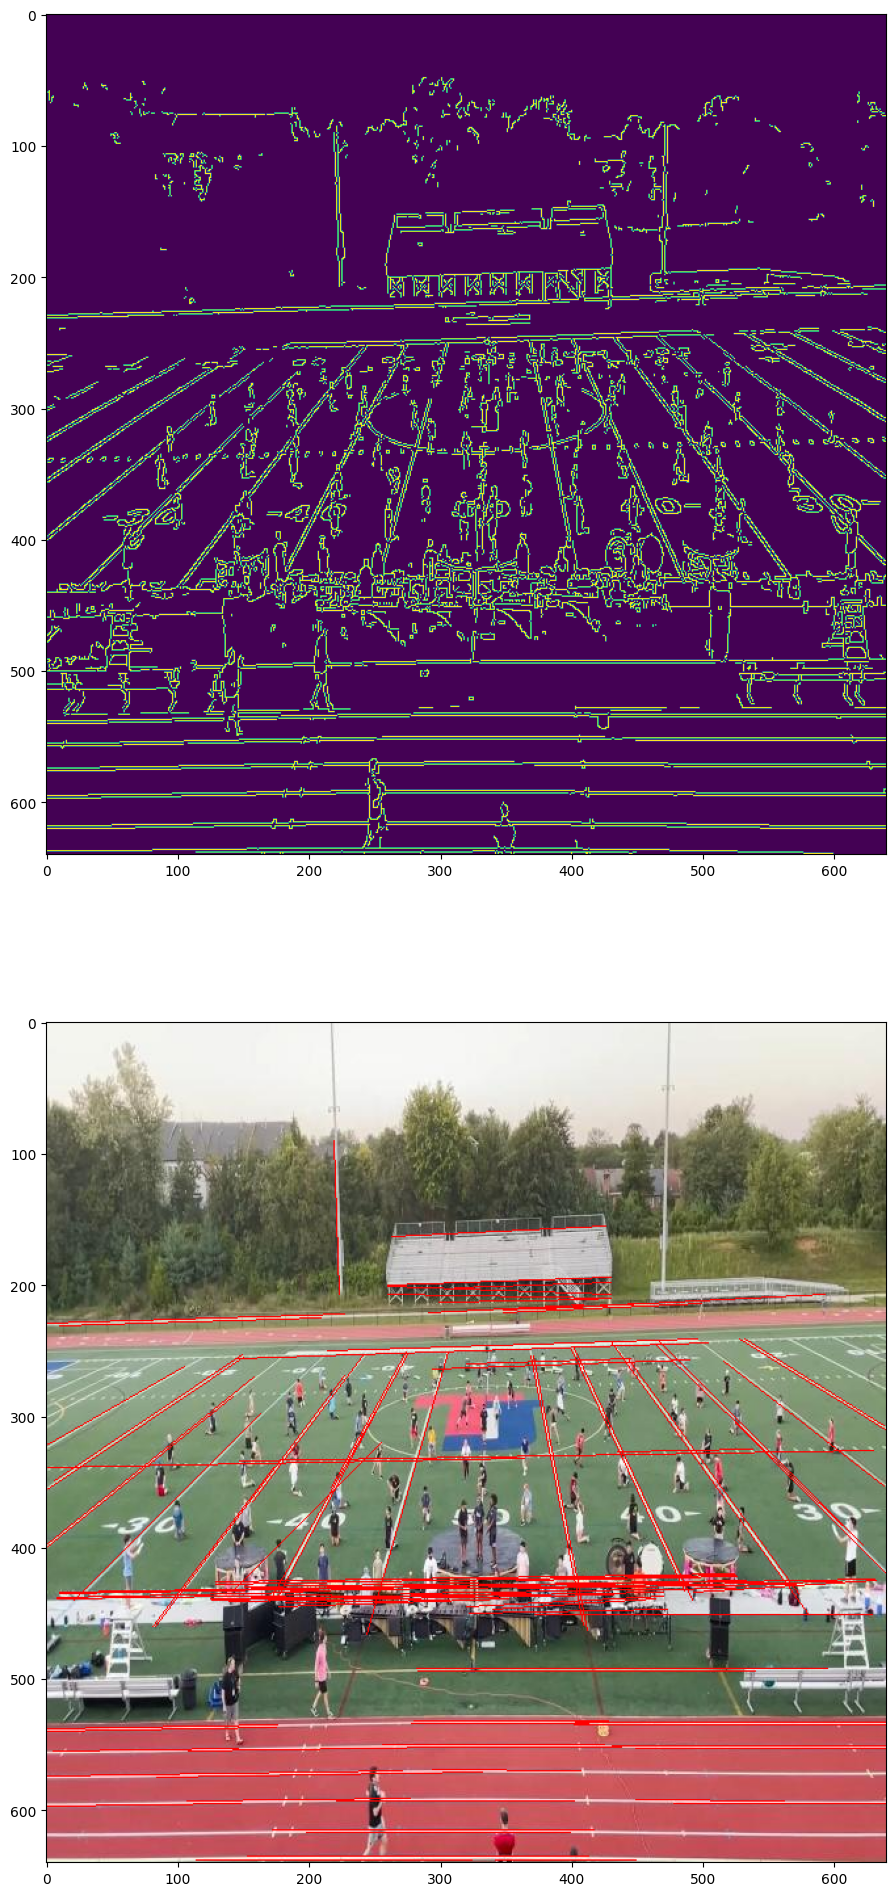

In [38]:
# Find lines using opencv Robust Hough Line Transform and draw them
gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
edges = cv2.Canny(gray, 200, 300, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=15)
def getlineimage(im, lines):
    line_image = im.copy()
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    return line_image
fig, ax = plt.subplots(2, 1, figsize=(24, 24))
ax[0].imshow(edges)
ax[1].imshow(getlineimage(train_image, lines))


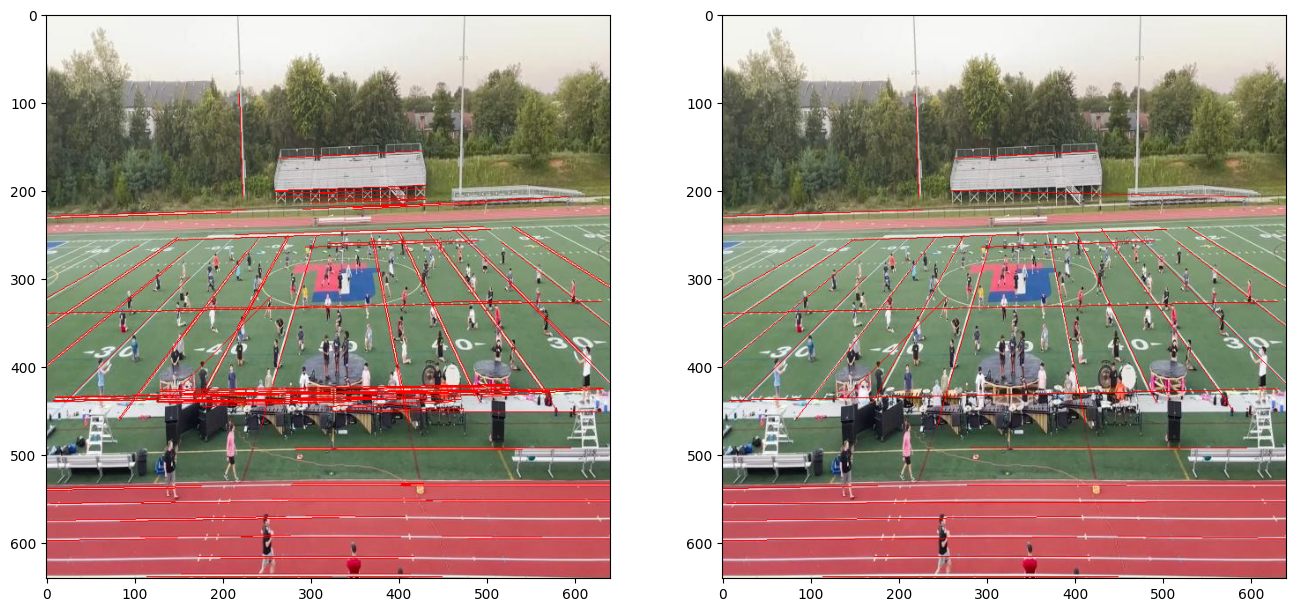

In [41]:
import math

# Borrowed from: https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp

class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

# Usage:
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)
bundler = HoughBundler(min_distance=10,min_angle=4)
bundled_lines = bundler.process_lines(lines)
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(getlineimage(train_image, lines))
ax[1].imshow(getlineimage(train_image, bundled_lines))

/home/lniewohner/miniconda3/bin/python: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from rich import inspect

# # Load the checkpoint  model in tensorflow and plot the model architecture 
# tf.debugging.set_log_device_placement(True) 
device_lib.list_local_devices()
checkpoint = "models/model.ckpt-399731.meta"

# Disable eager execution
tf.compat.v1.disable_eager_execution()
# # Load the model from checkpoint
with tf.compat.v1.Session() as sess:
    # Load the checkpoint using a MetaGraph
    with tf.device('/device:GPU:0'): 
        # Load the weights
        saver = tf.compat.v1.train.import_meta_graph(checkpoint)
        
        # Plot the model
        # Get the default graph
        graph = tf.compat.v1.get_default_graph()

        # Print the operations in the graph
        for op in graph.get_operations():
            print(op.name)
            

        # Plot the model architecture
        tf.compat.v1.summary.FileWriter("logs/", graph)
        
        # saver.restore(sess, checkpoint)
        # # Get the graph for this session
        # graph = tf.get_default_graph()
        # # Print the operations in the graph
        # # for op in graph.get_operations():
        # #     print(op.name)
            
        # # Plot it!
        # # tf.compat.v1.keras.utils.plot_model(graph, show_shapes=True, show_layer_names=True, to_file='model.png')
        # graph_def = tf.get_default_graph().as_graph_def()
        # source = graphviz.Source(tf.compat.v1.graph_util.convert_variables_to_constants(sess, graph_def, ['predictions', 'scores', 'predicted_length', 'predicted_text', 'predicted_conf', 'normalized_seq_conf']).SerializeToString())
        # source.render("model", format="png", cleanup=True)

: 

loading Roboflow workspace...
loading Roboflow project...


{'responses': [{}]}

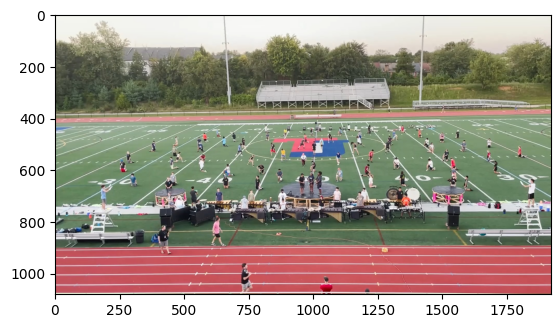

In [ ]:
# Using old Tensorflow models is a pain! This is way APIs exist. I just discovered google gives 1k free requests for vision API. 
# I'm going to use that instead, since OCR is not the focus of this project.
# Of course, we can't add dependencies, so I'm going to have to use the REST API.
import requests
import json

from roboflow import Roboflow
# load API key from .env.local
import os
from dotenv import load_dotenv
from glob import glob
import cv2
from rich.pretty import pprint
import matplotlib.pyplot as plt
import base64

load_dotenv()
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("lucasland").project("marching-band-drill-analysis-mheaa")
version = project.version(1)
dataset = version.download("coco", location="data/drill")


# Load the image
# IMAGE_NUM = 10
# images = glob(dataset.location + "/train/*.jpg")
# image = cv2.imread(images[IMAGE_NUM])
image = cv2.imread("data/drill/band_mp4-27.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

# Convert the image to base64
_, image_encoded = cv2.imencode('.jpg', image)
image_encoded = image_encoded.tobytes()
image_base64 = base64.b64encode(image_encoded).decode()

# Make the request
# REMEMBER TO INCLUDE THE KEY in plaintext when submitting this assignment
# But I'm not about to put my key in plaintext on the internet (not today, internet!)
# Please don't make more than 1k requests :)
# Or I guess 201k requests bc of a trial credit I have
url = "https://vision.googleapis.com/v1/images:annotate?key=" + os.getenv("GOOGLE_VISION_API_KEY")
data = {
  "requests": [
    {
      "image": {
        "content": image_base64
      },
      "features": [
        {
          "type": "TEXT_DETECTION"
        }
      ]
    }
  ]
}
response = requests.post(url, json=data)
response = response.json()

# Parse the response
pprint(response)

# There are definitely some images where this fails because the text is partially occluded. 
# I'm wave this off as something a full solution would solve with tracking between frames.
# Orrrr I think I'm going to need to have a manual yard line entry, because the very warped images tend to break this OCR.
# And again: not the focus of this project!

### Convert roboflow line number annotations to the FSNS format for fine-tuning the Attention OCR model

#### NOTE: WE DECIDED TO DROP THIS FINE-TUNING

In [ ]:
# Start by loading the example dataset to get the format right
# It is a TFRecord dataset.

import tensorflow as tf

# Load the dataset
# Specify the path to your TFRecord file
tfrecord_file = 'data/fieldnumbers/example_data'

# Create a TFRecordDataset
dataset = tf.data.TFRecordDataset(tfrecord_file)
sample = dataset.as_numpy_iterator().next()

# Parse the TFRecord
# feature_description = {
#     'image': tf.io.FixedLenFeature([], tf.string),
#     'label': tf.io.FixedLenFeature([], tf.int64),
# }
zero = tf.zeros([1], dtype=tf.int64)
keys_to_features = {
      'image/encoded':
      tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/format':
      tf.io.FixedLenFeature((), tf.string, default_value='png'),
      'image/width':
      tf.io.FixedLenFeature([1], tf.int64, default_value=zero),
      'image/orig_width':
      tf.io.FixedLenFeature([1], tf.int64, default_value=zero),
      'image/class':
      tf.io.FixedLenFeature(37, tf.int64),
      'image/unpadded_class':
      tf.io.VarLenFeature(tf.int64),
      'image/text':
      tf.io.FixedLenFeature([1], tf.string, default_value=''),
  }


# Parse the TFRecord
def _parse_function(proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(proto, keys_to_features)
record  = _parse_function(sample)
record

{'image/unpadded_class': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fde44b742b0>,
 'image/class': <tf.Tensor: shape=(37,), dtype=int64, numpy=
 array([ 49,  11,   5,   0,  47,   5,  21,  21,   5,  33,  12,   7, 133,
        133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133,
        133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133])>,
 'image/encoded': <tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x00\x96\x08\x02\x00\x00\x00\x8dyaf\x00\x00\x00\tpHYs\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9db&2\x00\x00 \x00IDATx\x9c\xa4\xbd\xd9\x96$\xc9\x91%&\x8b\xaa\x9a\xf9\x16\x11\x99UYUh4\x9a\xe7\xb0y\x0e\x7fv^\xf9\xc0\x7f\xe0\x1b\x1f\xf8;=\xbd\xcc\x00\xa8\xca%2|1U\x95e\x1eD\xcd\xc2#\xb3\xd0 \x87V\xc8@\xf8\x12\xe6f\xaa\xb2\\\xb9\xb28\xfe\x9f\xff\xc7\x7fqw\x00\x88\x9f\xaajf\x88\x08\x00\xf7?\x19\x10\xd6#\xde\xb9\xbd\xb4=\x1c\xe7\x01wrB\xc2\xbb\xc3\xdd[k\xf1\xfe\xfb\x83\x1c\xd0\xbfy\xee\xf5\x84\xdf<\xe3w\x7f\xbd\x9

In [13]:
from roboflow import Roboflow
import fiftyone as fo
# load API key from .env.local
import os
from dotenv import load_dotenv
load_dotenv()
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("lucasland").project("marching-band-drill-analysis-mheaa")
version = project.version(1)
dataset = version.download("coco", location="data/drill")

# Load the dataset
dataset = fo.Dataset.from_dir(
    dataset_dir="data/drill",
    dataset_type=fo.types.COCODetectionDataset,
    data_path="train",
    labels_path="train/_annotations.coco.json",
)



loading Roboflow workspace...
loading Roboflow project...
 100% |███████████████████| 39/39 [2.1s elapsed, 0s remaining, 19.0 samples/s]      


['_DOCUMENT_CLS', '__class__', '__contains__', '__copy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_collection', '_dataset', '_dataset_id', '_doc', '_excluded_fields', '_filtered_fields', '_frames', '_get_field_names', '_id', '_in_db', '_iter_label_fields', '_parse_fields', '_parse_fields_video', '_reload_parents', '_save', '_secure_media', '_selected_fields', '_to_db_fields', '_view', 'add_labels', 'clear_field', 'compute_metadata', 'copy', 'created_at', 'dataset', 'dataset_id', 'detections', 'excluded_field_names', 'field_names', 'filename', 'filepath', 'filtered_field_names', 'get_field', 'has_field', 'id', 'in_dataset', 'ite

In [ ]:
import cv2
# https://stackoverflow.com/questions/44430310/how-to-create-dataset-in-the-same-format-as-the-fsns-dataset
def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

length = 37
null_char_id = 133
charset = "0123456789abcdefghijklmnopqrstuvwxyz"
def encode_utf8_string(text, charset, length, null_char_id):
    char_ids_padded = [null_char_id]*length
    char_ids_unpadded = []
    for i, char in enumerate(text):
        if i >= length:
            break
        if char in charset:
            char_ids_padded[i] = charset.index(char)
            char_ids_unpadded.append(charset.index(char))
    return char_ids_padded, char_ids_unpadded


# Use Fiftyone to iterate over the images and annotations in the dataset
for sample in dataset.take(5):
  
  # Load the image
  img = cv2.imload(sample["image"])
  
  
  
  char_ids_padded, char_ids_unpadded = encode_utf8_string(
    text, charset, length, null_char_id)
  example = tf.train.Example(features=tf.train.Features(
    feature={
      'image/format': _bytes_feature("PNG"),
      'image/encoded': _bytes_feature(img.tostring()),
      'image/class': _int64_feature(char_ids_padded),
      'image/unpadded_class': _int64_feature(char_ids_unpadded),
      'height': _int64_feature(img.shape[0]),
      'width': _int64_feature(img.shape[1]),
      'orig_width': _int64_feature(img.shape[1]/num_of_views),
      'image/text': _bytes_feature(text)
    }
  ))